In [126]:
import numpy as np
import cv2
from EstimateFundamentalMatrix import *
from GetInliersRANSAC import *
from EssentialMatrixFromFundamentalMatrix import *
from ExtractCameraPose import *
from LinearTriangulation import *
from DisambiguateCameraPose  import *
from PnPRansac import *
from NonLinearPnP import *


from Utils.ImageUtils import *
from Utils.DataLoader import *
from Utils.MiscUtils import *
from matplotlib import pyplot as plt

import scipy.optimize as optimize
from scipy.sparse import lil_matrix
import time
from scipy.optimize import least_squares


K = np.array([[568.996140852, 0, 643.21055941],[0, 568.988362396, 477.982801038],[0, 0, 1]]).reshape(3,3)

In [251]:
def project3DPoints(K, R, C, X, image, points):
    I = np.identity(3)
    P = np.dot(K, np.dot(R, np.hstack((I, -C.reshape(3,1)))))
    if X.shape[1] != 4:
        X = homo(X)
    x = np.dot(P, X.T)
    # x01 = np.dot(P1, X01.T)

    x = x/x[2,:]

    xi = x[0, :].T
    yi = x[1, :].T
    im = image.copy()
    for i in range(points.shape[0]):

        x1, y1 = xi[i], yi[i]
        x2, y2 = points[i, 0], points[i, 1]
        cv2.circle(im, (int(x1), int(y1)), 3, (255,0,0), -1)
        cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), -1)

    cv2.imshow("im", im)
    cv2.waitKey() 
    cv2.destroyAllWindows()

In [16]:
def ProjectionMatrix(R,C,K):
    C = np.reshape(C, (3, 1))        
    I = np.identity(3)
    P = np.dot(K, np.dot(R, np.hstack((I, -C))))
    return P

def NonLinearTriangulation(K, pts1, pts2, x3D, R1, C1, R2, C2):
    
    P1 = ProjectionMatrix(R1,C1,K) 
    P2 = ProjectionMatrix(R2,C2,K)
    # pts1, pts2, x3D = pts1, pts2, x3D
    
    if pts1.shape[0] != pts2.shape[0] != x3D.shape[0]:
        raise 'Check point dimensions - level nlt'

    x3D_ = []
    for i in range(len(x3D)):
        optimized_params = optimize.least_squares(fun=ReprojectionLoss, x0=x3D[i], method="trf", args=[pts1[i], pts2[i], P1, P2])
        X1 = optimized_params.x
        x3D_.append(X1)
        # x3D_.append(X1[:3])
    return np.array(x3D_)

def ReprojectionLoss(X, pts1, pts2, P1, P2):
    
    # X = homo(X.reshape(1,-1)).reshape(-1,1) # make X a column of homogenous vector
    
    p1_1T, p1_2T, p1_3T = P1 # rows of P1
    p1_1T, p1_2T, p1_3T = p1_1T.reshape(1,-1), p1_2T.reshape(1,-1),p1_3T.reshape(1,-1)

    p2_1T, p2_2T, p2_3T = P2 # rows of P2
    p2_1T, p2_2T, p2_3T = p2_1T.reshape(1,-1), p2_2T.reshape(1,-1), p2_3T.reshape(1,-1)

    ## reprojection error for reference camera points - j = 1
    u1,v1 = pts1[0], pts1[1]
    u1_proj = np.divide(p1_1T.dot(X) , p1_3T.dot(X))
    v1_proj =  np.divide(p1_2T.dot(X) , p1_3T.dot(X))
    E1= np.square(v1 - v1_proj) + np.square(u1 - u1_proj)

    
    ## reprojection error for second camera points - j = 2    
    u2,v2 = pts2[0], pts2[1]
    u2_proj = np.divide(p2_1T.dot(X) , p2_3T.dot(X))
    v2_proj =  np.divide(p2_2T.dot(X) , p2_3T.dot(X))    
    E2= np.square(v2 - v2_proj) + np.square(u2 - u2_proj)
    
    error = E1 + E2
    return error.squeeze()


def meanReprojectionError(x3D, pts1, pts2, R1, C1, R2, C2, K ):    
    Error = []
    for pt1, pt2, X in zip(pts1, pts2, x3D):
        e1,e2 = ReprojectionError(X, pt1, pt2, R1, C1, R2, C2, K )
        Error.append(e1+e2)
        
    return np.mean(Error)

def ReprojectionError(X, pt1, pt2, R1, C1, R2, C2, K ):
    
    P1 = ProjectionMatrix(R1,C1,K) 
    P2 = ProjectionMatrix(R2,C2,K)

    # X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector
    
    p1_1T, p1_2T, p1_3T = P1 # rows of P1
    p1_1T, p1_2T, p1_3T = p1_1T.reshape(1,-1), p1_2T.reshape(1,-1),p1_3T.reshape(1,-1)

    p2_1T, p2_2T, p2_3T = P2 # rows of P2
    p2_1T, p2_2T, p2_3T = p2_1T.reshape(1,-1), p2_2T.reshape(1,-1), p2_3T.reshape(1,-1)

    ## reprojection error for reference camera points - j = 1
    u1,v1 = pt1[0], pt1[1]
    u1_proj = np.divide(p1_1T.dot(X) , p1_3T.dot(X))
    v1_proj =  np.divide(p1_2T.dot(X) , p1_3T.dot(X))
    E1= np.square(v1 - v1_proj) + np.square(u1 - u1_proj)
    
    ## reprojection error for second camera points - j = 2    
    u2,v2 = pt2[0], pt2[1]
    u2_proj = np.divide(p2_1T.dot(X) , p2_3T.dot(X))
    v2_proj =  np.divide(p2_2T.dot(X) , p2_3T.dot(X))
    
    E2= np.square(v2 - v2_proj) + np.square(u2 - u2_proj)
    
    return E1, E2

def projectPts(R, C, x3D, K):
    I  = np.identity(3)
    P2 = np.dot(K, np.dot(R, np.hstack((I, -C.reshape(3,1)))))
    x3D_4 = homo(x3D)
    x_proj = np.dot(P2, x3D_4.T)
    x_proj = (x_proj/x_proj[2,:]).T
    return x_proj


In [17]:
def showMatches(image_1, image_2, pts1, pts2, color, file_name):
#     file_name =  None
    # image_1 = img_1
    # image_2 = img_2

    image_1, image_2 = makeImageSizeSame([image_1, image_2])
    concat = np.concatenate((image_1, image_2), axis = 1)

    if pts1 is not None:
        corners_1_x = pts1[:,0].copy().astype(int)
        corners_1_y = pts1[:,1].copy().astype(int)
        corners_2_x = pts2[:,0].copy().astype(int)
        corners_2_y = pts2[:,1].copy().astype(int)
        corners_2_x += image_1.shape[1]

        for i in range(corners_1_x.shape[0]):
            cv2.line(concat, (corners_1_x[i], corners_1_y[i]), (corners_2_x[i] ,corners_2_y[i]), color, 1)
    cv2.imshow(file_name, concat)
    cv2.waitKey() 
    if file_name is not None:    
        cv2.imwrite(file_name, concat)
    cv2.destroyAllWindows()
    return concat
def showAllMatches(images, feature_x, feature_y, feature_flag, total_images):
    for i in range(0, total_images-1):
        for j in range(i+1, total_images):
            idx = np.where(feature_flag[:,i] & feature_flag[:,j])
            pts1 = np.hstack((feature_x[idx, i].reshape((-1, 1)), feature_y[idx, i].reshape((-1, 1))))
            pts2 = np.hstack((feature_x[idx, j].reshape((-1, 1)), feature_y[idx, j].reshape((-1, 1))))
            filename = '../Results/' + str(i) + str(j) + ".png"
            concat = showMatches(images[i], images[j], pts1, pts2, (0,0,255), filename)
############################################################################################################            
def showMatches_filtered(image_1, image_2, pts1, pts2, color1, pts1_filt, pts2_filt, color2, file_name):
    image_1, image_2 = makeImageSizeSame([image_1, image_2])
    concat = np.concatenate((image_1, image_2), axis = 1)

    if pts1 is not None:
        corners_1_x = pts1[:,0].copy().astype(int)
        corners_1_y = pts1[:,1].copy().astype(int)
        corners_2_x = pts2[:,0].copy().astype(int)
        corners_2_y = pts2[:,1].copy().astype(int)
        corners_2_x += image_1.shape[1]

        for i in range(corners_1_x.shape[0]):
            cv2.line(concat, (corners_1_x[i], corners_1_y[i]), (corners_2_x[i] ,corners_2_y[i]), color1, 1)

    if pts1_filt is not None:
        corners_1_x = pts1_filt[:,0].copy().astype(int)
        corners_1_y = pts1_filt[:,1].copy().astype(int)
        corners_2_x = pts2_filt[:,0].copy().astype(int)
        corners_2_y = pts2_filt[:,1].copy().astype(int)
        corners_2_x += image_1.shape[1]

        for i in range(corners_1_x.shape[0]):
            cv2.line(concat, (corners_1_x[i], corners_1_y[i]), (corners_2_x[i] ,corners_2_y[i]), color2, 1)
    
    
    cv2.imshow(file_name, concat)
    cv2.waitKey() 
    if file_name is not None:    
        cv2.imwrite(file_name, concat)
    cv2.destroyAllWindows()


def showFilteredMatches(images, feature_x, feature_y, filtered_feature_flag, feature_flag, total_images):
    for i in range(0, total_images-1):
        for j in range(i+1, total_images):
                        
            idx = np.where(feature_flag[:,i] & feature_flag[:,j])
            pts1 = np.hstack((feature_x[idx, i].reshape((-1, 1)), feature_y[idx, i].reshape((-1, 1))))
            pts2 = np.hstack((feature_x[idx, j].reshape((-1, 1)), feature_y[idx, j].reshape((-1, 1))))

            idx = np.where(filtered_feature_flag[:,i] & filtered_feature_flag[:,j])
            pts1_filt = np.hstack((feature_x[idx, i].reshape((-1, 1)), feature_y[idx, i].reshape((-1, 1))))
            pts2_filt = np.hstack((feature_x[idx, j].reshape((-1, 1)), feature_y[idx, j].reshape((-1, 1))))
            
            filename = '../Results/filtered/' + str(i) + str(j) + ".png"
            showMatches_filtered(images[i], images[j], pts1, pts2,(0,0,255), pts1_filt, pts2_filt, (0,255,0), filename)

            
############################################################################################################            

In [18]:
def errorF(pts1, pts2, F): 
    """
    check the epipolar constraint
    """
    x1,x2 = pts1, pts2
    x1tmp=np.array([x1[0], x1[1], 1])
    x2tmp=np.array([x2[0], x2[1], 1]).T

    error = np.dot(x2tmp, np.dot(F, x1tmp))
    
    return np.abs(error)

def getInliers(pts1, pts2, idx):
    n_iterations = 2000
    error_thresh = 0.002
    inliers_thresh = 0
    chosen_indices = []
    chosen_f = None

    for i in range(0, n_iterations):
  
        #select 8 points randomly
        n_rows = pts1.shape[0]
        random_indices = np.random.choice(n_rows, size=8)
        pts1_8 = pts1[random_indices, :] 
        pts2_8 = pts2[random_indices, :] 
        f_8 = EstimateFundamentalMatrix(pts1_8, pts2_8)
        # f_8, _ = cv2.findFundamentalMat(np.int32(features_8[:, 3:5]), np.int32(features_8[:, 5:7]),cv2.FM_LMEDS)
        indices = []
        if f_8 is not None:
            for j in range(n_rows):

                error = errorF(pts1[j, :], pts2[j, :], f_8)
                
                if error < error_thresh:
                    indices.append(idx[j])

        if len(indices) > inliers_thresh:
            inliers_thresh = len(indices)
            chosen_indices = indices
            chosen_f = f_8

    return chosen_f, chosen_indices

In [19]:
def EstimateFundamentalMatrix(pts1, pts2):
    normalised = True

    x1,x2 = pts1, pts2

    if x1.shape[0] > 7:
        if normalised == True:
            x1_norm, T1 = normalize(x1)
            x2_norm, T2 = normalize(x2)
        else:
            x1_norm,x2_norm = x1,x2
            
        A = np.zeros((len(x1_norm),9))
        for i in range(0, len(x1_norm)):
            x_1,y_1 = x1_norm[i][0], x1_norm[i][1]
            x_2,y_2 = x2_norm[i][0], x2_norm[i][1]
            A[i] = np.array([x_1*x_2, x_2*y_1, x_2, y_2*x_1, y_2*y_1, y_2, x_1, y_1, 1])

        U, S, VT = np.linalg.svd(A, full_matrices=True)
        F = VT.T[:, -1]
        F = F.reshape(3,3)

        u, s, vt = np.linalg.svd(F)
        s = np.diag(s)
        s[2,2] = 0
        F = np.dot(u, np.dot(s, vt))
        
        if normalised:
            F = np.dot(T2.T, np.dot(F, T1))
            F = F / F[2,2]
        return F

    else:
        return None

In [20]:
def PnP(X_set, x_set, K):
    N = X_set.shape[0]
    
    X_4 = homo(X_set)
    x_3 = homo(x_set)
    
    # normalize x
    K_inv = np.linalg.inv(K)
    x_n = K_inv.dot(x_3.T).T
    
    for i in range(N):
        X = X_4[i].reshape((1, 4))
        zeros = np.zeros((1, 4))
        
        u, v, _ = x_n[i]
        
        u_cross = np.array([[0, -1, v],
                            [1,  0 , -u],
                            [-v, u, 0]])
        X_tilde = np.vstack((np.hstack((   X, zeros, zeros)), 
                            np.hstack((zeros,     X, zeros)), 
                            np.hstack((zeros, zeros,     X))))
        a = u_cross.dot(X_tilde)
        
        if i > 0:
            A = np.vstack((A, a))
        else:
            A = a
            
    _, _, VT = np.linalg.svd(A)
    P = VT[-1].reshape((3, 4))
    R = P[:, :3]
    U_r, D, V_rT = np.linalg.svd(R) # to enforce Orthonormality
    R = U_r.dot(V_rT)
    
    C = P[:, 3]
    C = - np.linalg.inv(R).dot(C)
    
    if np.linalg.det(R) < 0:
        R = -R
        C = -C
        
    return R, C

def homo(pts):
    return np.hstack((pts, np.ones((pts.shape[0], 1))))

def PnPError(x, X, R, C, K):
    u,v = x
    X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector
    C = C.reshape(-1, 1)
    P = ProjectionMatrix(R,C,K)
    p1, p2, p3 = P
        
    u_proj = np.divide(p1.dot(X) , p3.dot(X))
    v_proj =  np.divide(p2.dot(X) , p3.dot(X))

    x_proj = np.hstack((u_proj, v_proj))
    x = np.hstack((u, v))
    e = np.linalg.norm(x - x_proj)
#     e = np.sqrt(np.square(u - u_proj) + np.square(v - v_proj))
    return  e

def PnPRANSAC(K, features, x3D, n_iterations = 1000, error_thresh = 5):

    inliers_thresh = 0
    chosen_indices = []
    chosen_R, chosen_t = None, None
    n_rows = x3D.shape[0]
    
    for i in range(0, n_iterations):
        
        #select 6 points randomly
        random_indices = np.random.choice(n_rows, size=6)
        X_set, x_set = x3D[random_indices], features[random_indices]
        
        R,C = PnP(X_set, x_set, K)
        
        indices = []
        errors = []
        if R is not None:
            for j in range(n_rows):
                feature = features[j]
                X = x3D[j]
                error = PnPError(feature, X, R, C, K)

                if error < error_thresh:
                    indices.append(j)
                    
        if len(indices) > inliers_thresh:
            inliers_thresh = len(indices)
            chosen_indices = indices
            chosen_R = R
            chosen_t = C
            
    #     filtered_features = features[chosen_indices, :]
    return chosen_R, chosen_t

In [256]:
Rotation

scipy.spatial.transform.rotation.Rotation

In [153]:
def getQuaternion(R2):
    Q = Rotation.from_matrix(R2)
    return Q.as_quat()

def getEuler(R2):
    euler = Rotation.from_matrix(R2)
    return euler.as_rotvec()

def getRotation(Q, type_ = 'q'):
    if type_ == 'q':
        R = Rotation.from_quat(Q)
        return R.as_matrix()
    elif type_ == 'e':
        R = Rotation.from_rotvec(Q)
        return R.as_matrix()
    

def NonLinearPnP(K, pts, x3D, R0, C0):

    Q = getQuaternion(R0)
    X0 = [Q[0] ,Q[1],Q[2],Q[3], C0[0], C0[1], C0[2]] 

    optimized_params = optimize.least_squares(
        fun = PnPLoss,
        x0=X0,
        method="trf",
        args=[x3D, pts, K])
    X1 = optimized_params.x
    Q = X1[:4]
    C = X1[4:]
    R = getRotation(Q)
    return R, C


def PnPLoss(X0, x3D, pts, K):
    
    Q, C = X0[:4], X0[4:].reshape(-1,1)
    R = getRotation(Q)
    P = ProjectionMatrix(R,C,K)
    
    Error = []
    for X, pt in zip(x3D, pts):

        p_1T, p_2T, p_3T = P# rows of P
        p_1T, p_2T, p_3T = p_1T.reshape(1,-1), p_2T.reshape(1,-1), p_3T.reshape(1,-1)


        X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector
        ## reprojection error for reference camera points 
        u, v = pt[0], pt[1]
        u_proj = np.divide(p_1T.dot(X) , p_3T.dot(X))
        v_proj =  np.divide(p_2T.dot(X) , p_3T.dot(X))

        E = np.square(v - v_proj) + np.square(u - u_proj)

        Error.append(E)

    sumError = np.mean(np.array(Error).squeeze())
    return sumError

# Read Data

In [22]:
folder_name = "../Data/"
total_images = 6
images = readImageSet(folder_name, total_images)

"""
 read the feature correspondencs as n x n_images matrix, 
 if image 1 and image 2 have correspondences, then column 1 and column 2 has data in it
 
 In every row, the non zero column positions signify that there are point correspondences between those images
""" 
feature_x, feature_y,  feature_flag, feature_descriptor = extractMatchingFeaturesFromFileNew(folder_name, total_images)

Reading images from  ../Data/


# Show All Matches

In [18]:
showAllMatches(images, feature_x, feature_y, feature_flag, total_images)

# Filter Points

In [13]:
"""
givefiltered_feature_flagta points, we need high quality matches that are inliers in the fundamental matrices that we
wil be estimating
"""

filtered_feature_flag = np.zeros_like(feature_flag)
f_matrix = np.empty(shape=(total_images, total_images), dtype=object)

for i in range(0, total_images - 1):
    # filtered_feature_flag[:, i] = feature_descriptor[:,i]
    for j in range(i + 1, total_images):
        
        idx = np.where(feature_flag[:,i] & feature_flag[:,j])
        pts1 = np.hstack((feature_x[idx, i].reshape((-1, 1)), feature_y[idx, i].reshape((-1, 1))))
        pts2 = np.hstack((feature_x[idx, j].reshape((-1, 1)), feature_y[idx, j].reshape((-1, 1))))
        # showMatches(images[i], images[j], pts1, pts2, (0,255,0), None)
        idx = np.array(idx).reshape(-1)
        # print(len(idx))
        if len(idx) > 8:
            F_best, chosen_idx = getInliers(pts1, pts2, idx)
            print('At image : ',  i,j, '|| Number of inliers: ', len(chosen_idx), '/', len(idx) )            
            f_matrix[i, j] = F_best
            filtered_feature_flag[chosen_idx, j] = 1
            filtered_feature_flag[chosen_idx, i] = 1
            
# np.save('filtered_feature_flag.npy',filtered_feature_flag)
# np.save('f_matrix.npy',f_matrix)

At image :  0 1 || Number of inliers:  572 / 1426
At image :  0 2 || Number of inliers:  265 / 608
At image :  0 3 || Number of inliers:  175 / 470
At image :  1 2 || Number of inliers:  687 / 2052
At image :  1 3 || Number of inliers:  286 / 1073
At image :  2 3 || Number of inliers:  514 / 2293
At image :  2 4 || Number of inliers:  499 / 963
At image :  2 5 || Number of inliers:  278 / 449
At image :  3 4 || Number of inliers:  806 / 2160
At image :  3 5 || Number of inliers:  503 / 1151
At image :  4 5 || Number of inliers:  695 / 1965


In [30]:
# showFilteredMatches(images, feature_x, feature_y, feature_flag, filtered_feature_flag, total_images)
showFilteredMatches(images, feature_x, feature_y, filtered_feature_flag, feature_flag, total_images)

In [23]:
filtered_feature_flag = np.load('./tmp_files/filtered_feature_flag.npy', allow_pickle=True)
f_matrix = np.load('./tmp_files/f_matrix.npy', allow_pickle=True)

# For first 2 images

In [72]:
n,m = 0,1
F12 = f_matrix[n,m]
E12 = getEssentialMatrix(K, F12)
R_set, C_set = ExtractCameraPose(E12)

## linear triangulation

In [73]:
idx = np.where(filtered_feature_flag[:,n] & filtered_feature_flag[:,m])

pts1 = np.hstack((feature_x[idx, n].reshape((-1, 1)), feature_y[idx, n].reshape((-1, 1))))
pts2 = np.hstack((feature_x[idx, m].reshape((-1, 1)), feature_y[idx, m].reshape((-1, 1))))

R1_ = np.identity(3)
C1_ = np.zeros((3,1))
I = np.identity(3)
pts3D_4 = []
for i in range(len(C_set)):
    pts3D = []
    x1 = pts1
    x2 = pts2
    X = LinearTriangulation(K, C1_, R1_, C_set[i], R_set[i], x1, x2)
    X = X/X[:,3].reshape(-1,1)
    pts3D_4.append(X)

## Sanity Check: reproject 3D points to 2D

In [74]:
k = 0
project3DPoints(K, R_set[k], C_set[k], pts3D_4[k], images[1], pts2)
cv2.destroyAllWindows()

## Cheirality check

In [75]:
R_chosen, C_chosen, X = DisambiguatePose(R_set, C_set, pts3D_4)
X = X/X[:,3].reshape(-1,1)

## Sanity Check: Plot 3D points 

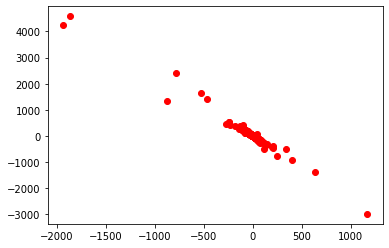

In [76]:
del_idx = np.where(X[:,2] < 0)

x = X[:,0]
y = X[:,1]
z = X[:,2]

fig = plt.figure()
# plt.scatter(x,z, color = 'blue')
plt.scatter(x, z, color='red')

# project3DPoints(K, R_chosen, C_chosen, X, images[1], pts2)

## Non Linear triangulation

In [77]:
x3D = X
R1, C1, = R1_, C1_
X_refined = NonLinearTriangulation(K, pts1, pts2, x3D, R1, C1, R_chosen, C_chosen)
X_refined = X_refined / X_refined[:,3].reshape(-1,1)

Before optimization:  15.35018676707696 After optimization : 15.25197935823187


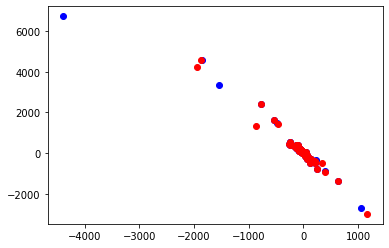

In [78]:
del_idx = np.where(X[:,2] < 0)

x = X[:,0]
y = X[:,1]
z = X[:,2]
x1 = X_refined[:,0]
y1 = X_refined[:,1]
z1 = X_refined[:,2]

fig = plt.figure()
plt.scatter(x1,z1, color = 'blue')
plt.scatter(x, z, color='red')

mean_error1 = meanReprojectionError(X, pts1, pts2, R1, C1, R_chosen, C_chosen, K )
mean_error2 = meanReprojectionError(X_refined, pts1, pts2, R1, C1, R_chosen, C_chosen, K )

print('Before optimization: ', mean_error1, 'After optimization :', mean_error2)

# Register Camera and add 3D points

In [79]:
X_all = np.zeros((feature_x.shape[0], 3))
camera_indices = np.zeros((feature_x.shape[0], 1), dtype = int) 
X_found = np.zeros((feature_x.shape[0], 1), dtype = int)

X_all[idx] = X[:, :3]
X_found[idx] = 1
camera_indices[idx] = 1

print(np.nonzero(X_found[idx])[0].shape)
X_found[np.where(X_all[:,2] < 0)] = 0
print(len(idx[0]), '--' ,np.nonzero(X_found[idx])[0].shape)

C_set_ = []
R_set_ = []

C0 = np.zeros(3)
R0 = np.identity(3)

C_set_.append(C0)
R_set_.append(R0)

C_set_.append(C_chosen)
R_set_.append(R_chosen)

(602,)
602 -- (537,)


## Sanity Check: plot the available X_all and remove negative points. Why? because they might cause trouble in future

Length of data found before.. 537


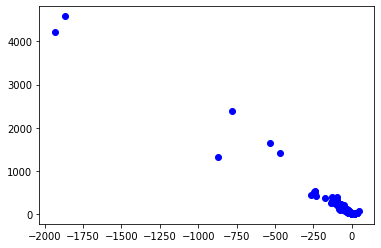

In [80]:
# run for 0,1
X_idx = np.where(X_found[:, 0] & filtered_feature_flag[:, 1])
print('Length of data found before..', len(X_idx[0]))

X = X_all[X_idx, :].reshape(-1,3)
pts = np.hstack((feature_x[X_idx, 1].reshape(-1,1), feature_y[X_idx, 1].reshape(-1,1)))
fig = plt.figure()
plt.scatter(X[:,0], X[:,2], color = 'blue')

project3DPoints(K, R_set_[1], C_set_[1], X, images[1], pts)

In [81]:
# Main pipeline

In [82]:
def getObservationsIndexAndVizMat(X_found, filtered_feature_flag, nCam):
    # find the 3d points such that they are visible in either of the cameras < nCam
    bin_temp = np.zeros((filtered_feature_flag.shape[0]), dtype = int)
    for n in range(nCam + 1):
        bin_temp = bin_temp | filtered_feature_flag[:,n]

    X_index = np.where((X_found.reshape(-1)) & (bin_temp))
    
    visiblity_matrix = X_found[X_index].reshape(-1,1)
    for n in range(nCam + 1):
        visiblity_matrix = np.hstack((visiblity_matrix, filtered_feature_flag[X_index, n].reshape(-1,1)))

    o, c = visiblity_matrix.shape
    return X_index, visiblity_matrix[:, 1:c]

def get2DPoints(X_index, visiblity_matrix, feature_x, feature_y):
    pts2D = []
    visible_feature_x = feature_x[X_index]
    visible_feature_y = feature_y[X_index]
    h, w = visiblity_matrix.shape
    for i in range(h):
        for j in range(w):
            if visiblity_matrix[i,j] == 1:
                pt = np.hstack((visible_feature_x[i,j], visible_feature_y[i,j]))
                pts2D.append(pt)
    return np.array(pts2D).reshape(-1, 2)             

def getCameraPointIndices(visiblity_matrix):
    camera_indices = []
    point_indices = []
    h, w = visiblity_matrix.shape
    for i in range(h):
        for j in range(w):
            if visiblity_matrix[i,j] == 1:
                camera_indices.append(j)
                point_indices.append(i)

    return np.array(camera_indices).reshape(-1), np.array(point_indices).reshape(-1)

In [84]:
##########################################################################################
##################### Compute Essential Matrix, Estimate Pose, Triangulate ###############
n,m = 0,1
F12 = f_matrix[n,m]
E12 = getEssentialMatrix(K, F12)
R_set, C_set = ExtractCameraPose(E12)

idx = np.where(filtered_feature_flag[:,n] & filtered_feature_flag[:,m])
pts1 = np.hstack((feature_x[idx, n].reshape((-1, 1)), feature_y[idx, n].reshape((-1, 1))))
pts2 = np.hstack((feature_x[idx, m].reshape((-1, 1)), feature_y[idx, m].reshape((-1, 1))))

R1_ = np.identity(3)
C1_ = np.zeros((3,1))
I = np.identity(3)
pts3D_4 = []
for i in range(len(C_set)):
    pts3D = []
    x1 = pts1
    x2 = pts2
    X = LinearTriangulation(K, C1_, R1_, C_set[i], R_set[i], x1, x2)
    X = X/X[:,3].reshape(-1,1)
    pts3D_4.append(X)

R_chosen, C_chosen, X = DisambiguatePose(R_set, C_set, pts3D_4)
X = X/X[:,3].reshape(-1,1)

X_refined = NonLinearTriangulation(K, pts1, pts2, X, R1_, C1_, R_chosen, C_chosen)
X_refined = X_refined / X_refined[:,3].reshape(-1,1)
########################################################################################

###################### Register Camera 1 and 2  #########################################

X_all = np.zeros((feature_x.shape[0], 3))
camera_indices = np.zeros((feature_x.shape[0], 1), dtype = int) 
X_found = np.zeros((feature_x.shape[0], 1), dtype = int)

X_all[idx] = X[:, :3]
X_found[idx] = 1
camera_indices[idx] = 1

# print(np.nonzero(X_found[idx])[0].shape)
X_found[np.where(X_all[:,2] < 0)] = 0
# print(len(idx[0]), '--' ,np.nonzero(X_found[idx])[0].shape)

C_set_ = []
R_set_ = []

C0 = np.zeros(3)
R0 = np.identity(3)
C_set_.append(C0)
R_set_.append(R0)

C_set_.append(C_chosen)
R_set_.append(R_chosen)

for i in range(2, total_images):

    feature_idx_i = np.where(X_found[:, 0] & filtered_feature_flag[:, i])
    if len(feature_idx_i[0]) < 8:
        print("Found ", len(feature_idx_i), "common points between X and ", i, " image")
        continue

    pts_i = np.hstack((feature_x[feature_idx_i, i].reshape(-1,1), feature_y[feature_idx_i, i].reshape(-1,1)))
    X = X_all[feature_idx_i, :].reshape(-1,3)
    #PnP
    R_init, C_init = PnPRANSAC(K, pts_i, X, n_iterations = 1000, error_thresh = 5)
    Ri, Ci = NonLinearPnP(K, pts_i, X, R_init, C_init)

    C_set_.append(Ci)
    R_set_.append(Ri)

    #trianglulation
    for j in range(0, i):
        # idx_X_pts = np.where(X_found[:, 0] & filtered_feature_flag[:, j] & filtered_feature_flag[:, i])
        idx_X_pts = np.where(filtered_feature_flag[:, j] & filtered_feature_flag[:, i])
        if (len(idx_X_pts[0]) < 8):
            continue

        x1 = np.hstack((feature_x[idx_X_pts, j].reshape((-1, 1)), feature_y[idx_X_pts, j].reshape((-1, 1))))
        x2 = np.hstack((feature_x[idx_X_pts, i].reshape((-1, 1)), feature_y[idx_X_pts, i].reshape((-1, 1))))

        X = LinearTriangulation(K, C_set_[j], R_set_[j], Ci, Ri, x1, x2)
        X = X/X[:,3].reshape(-1,1)
        X = NonLinearTriangulation(K, x1, x2, X, R_set_[j], C_set_[j], Ri, Ci)
        X = X/X[:,3].reshape(-1,1)


        X_all[idx_X_pts] = X[:,:3]
        X_found[idx_X_pts] = 1

        print("appended ", len(idx_X_pts[0]), " points between ", j ," and ", i)
        
    R_set_, C_set_, X_all = BundleAdjustment(X_all,X_found, feature_x, feature_y, filtered_feature_flag, R_set_, C_set_,  K, nCam = i)
    
    

appended  283  points between  0  and  2
appended  750  points between  1  and  2
appended  196  points between  0  and  3
appended  361  points between  1  and  3
appended  722  points between  2  and  3
appended  529  points between  2  and  4
appended  913  points between  3  and  4
appended  288  points between  2  and  5
appended  557  points between  3  and  5
appended  788  points between  4  and  5


# Sanity Check:  Plot 3D points

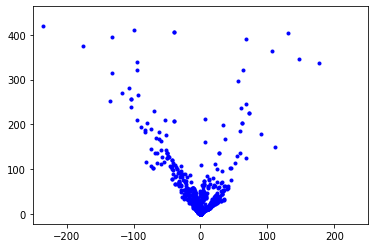

In [96]:
X_found[X_all[:,2] < 0] = 0
X_found[X_all[:,2] > 500] = 0
feature_idx = np.where(X_found[:, 0])
X = X_all[feature_idx]
fig = plt.figure()
x = X[:,0]
z = X[:,2]
# x[(x < -500) | (x > 500)] = 0 
# z[(z <= 0) | (z > 500)] = 0
# plt.axis('square')
plt.xlim(-250,  250)
# plt.axes().set_aspect('equal')

plt.scatter(x, z, marker = '.', color = 'blue', linewidths=1)

In [36]:
R_set_ = np.load('./tmp_files/R_set.npy',allow_pickle=True)
C_set_ = np.load('./tmp_files/C_set.npy',allow_pickle=True)
X_found = np.load('./tmp_files/X_found.npy',allow_pickle=True)
X_all = np.load('./tmp_files/X_all.npy',allow_pickle=True)

# Bundle Adjustment

In [124]:


def bundle_adjustment_sparsity(X_found, filtered_feature_flag, nCam):
    number_of_cam = nCam + 1
    X_index, visiblity_matrix = getObservationsIndexAndVizMat(X_found.reshape(-1), filtered_feature_flag, nCam)
    n_observations = np.sum(visiblity_matrix)
    n_points = len(X_index[0])

    m = n_observations * 2
    n = number_of_cam * 6 + n_points * 3
    A = lil_matrix((m, n), dtype=int)
    print(m, n)


    i = np.arange(n_observations)
    camera_indices, point_indices = getCameraPointIndices(visiblity_matrix)

    for s in range(6):
        A[2 * i, camera_indices * 6 + s] = 1
        A[2 * i + 1, camera_indices * 6 + s] = 1

    for s in range(3):
        A[2 * i, (nCam)* 6 + point_indices * 3 + s] = 1
        A[2 * i + 1, (nCam) * 6 + point_indices * 3 + s] = 1

    return A

# def project(points, camera_params, K):
#     """Convert 3-D points to 2-D by projecting onto images."""
#     points_proj = rotate(points, camera_params[:, :3])
#     points_proj += camera_params[:, 3:]
#     points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
#     return points_proj

def project(points_3d, camera_params, K):
    def projectPoint_(R, C, pt3D, K):
        P2 = np.dot(K, np.dot(R, np.hstack((np.identity(3), -C.reshape(3,1)))))
        x3D_4 = np.hstack((pt3D, 1))
        x_proj = np.dot(P2, x3D_4.T)
        x_proj /= x_proj[-1]
        return x_proj

    x_proj = []
    for i in range(len(camera_params)):
        R = getRotation(camera_params[i, :3], 'e')
        C = camera_params[i, 3:].reshape(3,1)
        pt3D = points_3d[i]
        pt_proj = projectPoint_(R, C, pt3D, K)[:2]
        x_proj.append(pt_proj)    
    return np.array(x_proj)

def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

def fun(x0, nCam, n_points, camera_indices, point_indices, points_2d, K):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    number_of_cam = nCam + 1
    camera_params = x0[:number_of_cam * 6].reshape((number_of_cam, 6))
    points_3d = x0[number_of_cam * 6:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices], K)
    error_vec = (points_proj - points_2d).ravel()
    
    return error_vec

def BundleAdjustment(X_all, X_found, feature_x, feature_y, filtered_feature_flag, R_set_, C_set_, K, nCam):
    
    X_index, visiblity_matrix = getObservationsIndexAndVizMat(X_found, filtered_feature_flag, nCam)
    points_3d = X_all[X_index]
    points_2d = get2DPoints(X_index, visiblity_matrix, feature_x, feature_y)

    RC_list = []
    for i in range(nCam+1):
        C, R = C_set_[i], R_set_[i]
        Q = getEuler(R)
        RC = [Q[0], Q[1], Q[2], C[0], C[1], C[2]]
        RC_list.append(RC)
    RC_list = np.array(RC_list).reshape(-1, 6)

    x0 = np.hstack((RC_list.ravel(), points_3d.ravel()))
    n_points = points_3d.shape[0]

    camera_indices, point_indices = getCameraPointIndices(visiblity_matrix)
    
    A = bundle_adjustment_sparsity(X_found, filtered_feature_flag, nCam)
    t0 = time.time()
    res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-12, method='dogbox',
                        args=(nCam, n_points, camera_indices, point_indices, points_2d, K))
    t1 = time.time()
    print('time to run BA :', t1-t0, 's \nA matrix shape: ' ,  A.shape, '\n############')
    
    x1 = res.x
    number_of_cam = nCam + 1
    optimized_camera_params = x1[:number_of_cam * 6].reshape((number_of_cam, 6))
    optimized_points_3d = x1[number_of_cam * 6:].reshape((n_points, 3))

    optimized_X_all = np.zeros_like(X_all)
    optimized_X_all[X_index] = optimized_points_3d

    optimized_C_set, optimized_R_set = [], []
    for i in range(len(optimized_camera_params)):
        R = getRotation(optimized_camera_params[i, :3], 'e')
        C = optimized_camera_params[i, 3:].reshape(3,1)
        optimized_C_set.append(C)
        optimized_R_set.append(R)
    
    return optimized_R_set, optimized_C_set, optimized_X_all


In [207]:
nCam = 5

    
X_index, visiblity_matrix = getObservationsIndexAndVizMat(X_found, filtered_feature_flag, nCam)
points_3d = X_all[X_index]
points_2d = get2DPoints(X_index, visiblity_matrix, feature_x, feature_y)

RC_list = []
for i in range(nCam+1):
    C, R = C_set_[i], R_set_[i]
    Q = getEuler(R)
    RC = [Q[0], Q[1], Q[2], C[0], C[1], C[2]]
    RC_list.append(RC)
RC_list = np.array(RC_list).reshape(-1, 6)

x0 = np.hstack((RC_list.ravel(), points_3d.ravel()))
n_points = points_3d.shape[0]

camera_indices, point_indices = getCameraPointIndices(visiblity_matrix)



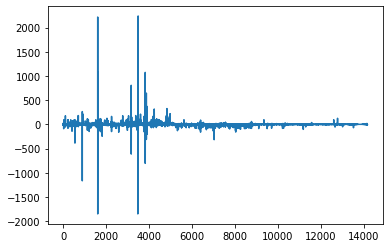

In [208]:
f0 = fun(x0, nCam, n_points, camera_indices, point_indices, points_2d, K)
plt.plot(f0)

In [211]:
A = bundle_adjustment_sparsity(X_found, filtered_feature_flag, nCam)
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-12, method='dogbox',
                    args=(nCam, n_points, camera_indices, point_indices, points_2d, K))
t1 = time.time()

14170 9672
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2350e+07                                    3.65e+08    
       1              3         1.4173e+07      8.18e+06       3.58e-02       1.36e+08    
       2              5         1.3800e+07      3.73e+05       3.52e-03       1.41e+08    
       3              7         1.3639e+07      1.61e+05       1.02e-03       1.25e+08    
       4             11         1.3634e+07      5.09e+03       4.99e-01       1.24e+08    
       5             12         1.3633e+07      1.26e+03       1.01e-01       1.24e+08    
       6             13         1.3632e+07      3.48e+02       2.36e-02       1.24e+08    
       7             14         1.3632e+07      3.54e+02       2.32e-02       1.24e+08    
       8             15         1.3632e+07      3.60e+02       2.28e-02       1.24e+08    
       9             16         1.3631e+07      3.68e+02       2.23e-02       1

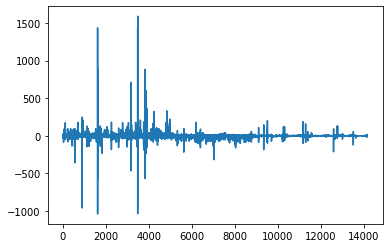

In [212]:
plt.plot(res.fun)

In [218]:
x1 = res.x
number_of_cam = nCam + 1
optimized_camera_params = x1[:number_of_cam * 6].reshape((number_of_cam, 6))
optimized_points_3d = x1[number_of_cam * 6:].reshape((n_points, 3))

optimized_X_all = np.zeros_like(X_all)
optimized_X_all[X_index] = optimized_points_3d

optimized_C_set, optimized_R_set = [], []
for i in range(len(optimized_camera_params)):
    R = getRotation(optimized_camera_params[i, :3], 'e')
    C = optimized_camera_params[i, 3:].reshape(3,1)
    optimized_C_set.append(C)
    optimized_R_set.append(R)
    


In [257]:
A

<14170x9672 sparse matrix of type '<class 'numpy.int64'>'
	with 127530 stored elements in List of Lists format>

In [ ]:
# Plot 3D points

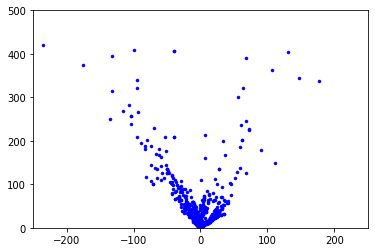

In [228]:
feature_idx = np.where(X_found[:, 0])
X = optimized_X_all[feature_idx]
fig = plt.figure()
x = X[:,0]
z = X[:,2]
x[(x < -500) | (x > 500)] = 0 
z[(z <= 0) | (z > 500)] = 0
# plt.axis('equal')
plt.xlim(-250,  250)
plt.ylim(0,  500)
plt.scatter(x, z, marker='.',linewidths=0.5, color = 'blue')

# Also main pipeline

In [19]:
A_list = []
for i in range(2, total_images):
    
    # select the indices that belong to the i-th image and previously found 3D pt set ( should be i-1)
    feature_idx_i = np.where(X_found[:, 0] & filtered_feature_flag[:, i])
    
    
    print('Length of data found before..', len(feature_idx_i[0]), len(np.nonzero(X_found[:, 0])[0]))
    if len(feature_idx_i[0]) < 8:
        print("Found ", len(feature_idx_i), "common points between X and ", i, " image")
        continue
    # obtain all the feature points that correspond to the i-th image
    pts_i = np.hstack((feature_x[feature_idx_i, i].reshape(-1,1), feature_y[feature_idx_i, i].reshape(-1,1)))
    
    # get the 3D points that we have estimated with previous i-1 th pose
    X = X_all[feature_idx_i, :].reshape(-1,3)
    camera_indices[feature_idx_i] = i
    
    #Obtain camera pose of the i-th image
    R_init, C_init = PnPRANSAC(K, pts_i, X, n_iterations = 1000, error_thresh = 5)
    Ri, Ci = NonLinearPnP(K, pts_i, X, R_init, C_init)
    
    # add the i-th camera pose to our records
    C_set_.append(Ci)
    R_set_.append(Ri)
    
    #trianglulation
    ## we use the currently known i-th pose and add the 3D points with respect
    # to the previously known j-th poses  
    for j in range(0, i):
        # idx_X_pts = np.where(X_found[:, 0] & filtered_feature_flag[:, j] & filtered_feature_flag[:, i])
        
        # find the indices where i and j image has point correspondences from our record 
        idx_X_pts = np.where(filtered_feature_flag[:, j] & filtered_feature_flag[:, i])
        if (len(idx_X_pts[0]) < 8):
            continue
        
        # using the indices, get the i and j th feature points 
        x1 = np.hstack((feature_x[idx_X_pts, j].reshape((-1, 1)), feature_y[idx_X_pts, j].reshape((-1, 1))))
        x2 = np.hstack((feature_x[idx_X_pts, i].reshape((-1, 1)), feature_y[idx_X_pts, i].reshape((-1, 1))))
        
        # get the 3D points of i-th and j-th image using their feature correspondences:
         
        X = LinearTriangulation(K, C_set_[j], R_set_[j], Ci, Ri, x1, x2)
        X = X/X[:,3].reshape(-1,1)
        X = NonLinearTriangulation(K, x1, x2, X, R_set_[j], C_set_[j], Ri, Ci)
        X = X/X[:,3].reshape(-1,1)

        print("appended ", len(idx_X_pts[0]), "points between ", j ," and ", i)

        X_all[idx_X_pts] = X[:,:3]
        X_found[idx_X_pts] = 1
        X_found[np.where(X_all[:,2] < 0)] = 0
camera_indices = camera_indices.ravel()

Length of data found before.. 104 537
appended  283 points between  0  and  2
appended  750 points between  1  and  2
Length of data found before.. 214 1254
appended  196 points between  0  and  3
appended  361 points between  1  and  3
appended  722 points between  2  and  3
Length of data found before.. 161 1876
appended  529 points between  2  and  4
appended  913 points between  3  and  4
Length of data found before.. 276 2894
appended  288 points between  2  and  5
appended  557 points between  3  and  5
appended  788 points between  4  and  5


In [30]:
np.save('R_set.npy',R_set_)
np.save('C_set.npy',C_set_)
np.save('X_found.npy',X_found)
np.save('X_all.npy',X_all)

## Plot 3D points

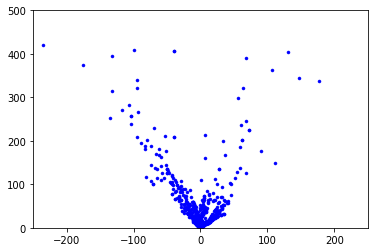

In [242]:
feature_idx = np.where(X_found[:, 0])
X = X_all[feature_idx]
fig = plt.figure()
x = X[:,0]
z = X[:,2]
x[(x < -500) | (x > 500)] = 0 
z[(z <= 0) | (z > 500)] = 0
# plt.axis('equal')
plt.xlim(-250,  250)
plt.ylim(0,  500)
plt.scatter(x, z, marker='.',linewidths=0.5, color = 'blue')

## Sanity Check: Reproject 3D points to 2D

In [246]:
R,C = R_set_[0], C_set_[0]

(3,)

In [253]:


for i in range(0, total_images):
    R = R_set_[i]
    C = C_set_[i]

    P = ProjectionMatrix(R,C,K)

    feature_idx = np.where(X_found[:, 0] & filtered_feature_flag[:, i])
    if len(feature_idx[0]) < 8:
        continue
        
    pts_i = np.hstack((feature_x[feature_idx, i].reshape(-1,1), feature_y[feature_idx, i].reshape(-1,1)))
    X = X_all[feature_idx]

    project3DPoints(K, R, C, X, images[i], pts_i)
    


In [ ]:
# meanReprojectionError(x3D, pts1, pts2, R1, C1, R2, C2, K )